In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, NASNetMobile, ResNet50V2, EfficientNetB0, DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, MaxPool2D
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
TRAINING_DIR = "baru//Training"
VALIDATION_DIR = "baru//validation"

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              class_mode='categorical',
                                                              target_size=(224, 224))


Found 4254 images belonging to 5 classes.
Found 964 images belonging to 5 classes.


In [4]:
print(train_generator.class_indices)

{'BercakHitam': 0, 'BukanDaunAnggur': 1, 'DaunSehat': 2, 'HawarDaun': 3, 'KaratDaun': 4}


In [5]:
# Pretrain Model
pre_trained_model = NASNetMobile(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    pre_trained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

19993432/19993432 [==============================] - 9s 0us/step


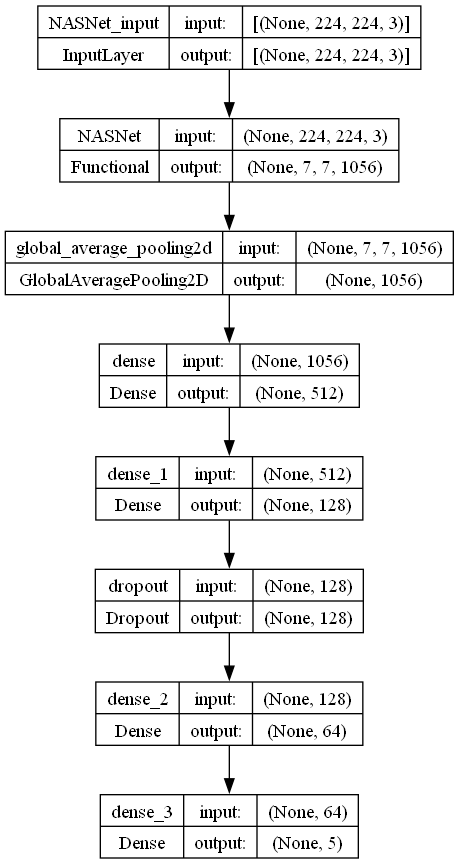

In [6]:
from tensorflow.keras.utils import plot_model

# visualisasi model
plot_model(model, to_file='nasnetmobile.png', show_shapes=True)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 global_average_pooling2d (G  (None, 1056)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               541184    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                        

In [8]:
int_lr = 0.0001
num_epochs = 100

# Early Stopping
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Model Checkpoint
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Nasnetbest_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Compile and Training
optimizer = tf.optimizers.Adam(learning_rate=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[earlystop_callback, checkpoint_callback]
)

Epoch 1/100
133/133 [==============================] - ETA: 0s - loss: 0.9655 - accuracy: 0.6229
Epoch 1: val_accuracy improved from -inf to 0.74585, saving model to Nasnetbest_weights.h5
133/133 [==============================] - 278s 2s/step - loss: 0.9655 - accuracy: 0.6229 - val_loss: 0.6416 - val_accuracy: 0.7459
Epoch 2/100
133/133 [==============================] - ETA: 0s - loss: 0.5715 - accuracy: 0.7755
Epoch 2: val_accuracy improved from 0.74585 to 0.80394, saving model to Nasnetbest_weights.h5
133/133 [==============================] - 297s 2s/step - loss: 0.5715 - accuracy: 0.7755 - val_loss: 0.5233 - val_accuracy: 0.8039
Epoch 3/100
133/133 [==============================] - ETA: 0s - loss: 0.4742 - accuracy: 0.8164
Epoch 3: val_accuracy improved from 0.80394 to 0.81120, saving model to Nasnetbest_weights.h5
133/133 [==============================] - 271s 2s/step - loss: 0.4742 - accuracy: 0.8164 - val_loss: 0.4677 - val_accuracy: 0.8112
Epoch 4/100
133/133 [=============

Epoch 28/100
133/133 [==============================] - ETA: 0s - loss: 0.0365 - accuracy: 0.9913
Epoch 28: val_accuracy improved from 0.92842 to 0.93050, saving model to Nasnetbest_weights.h5
133/133 [==============================] - 326s 2s/step - loss: 0.0365 - accuracy: 0.9913 - val_loss: 0.2093 - val_accuracy: 0.9305
Epoch 29/100
133/133 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.9932
Epoch 29: val_accuracy did not improve from 0.93050
133/133 [==============================] - 317s 2s/step - loss: 0.0299 - accuracy: 0.9932 - val_loss: 0.2233 - val_accuracy: 0.9243
Epoch 30/100
133/133 [==============================] - ETA: 0s - loss: 0.0241 - accuracy: 0.9953
Epoch 30: val_accuracy did not improve from 0.93050
133/133 [==============================] - 304s 2s/step - loss: 0.0241 - accuracy: 0.9953 - val_loss: 0.2695 - val_accuracy: 0.9160
Epoch 31/100
133/133 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9937
Epoch 31: val

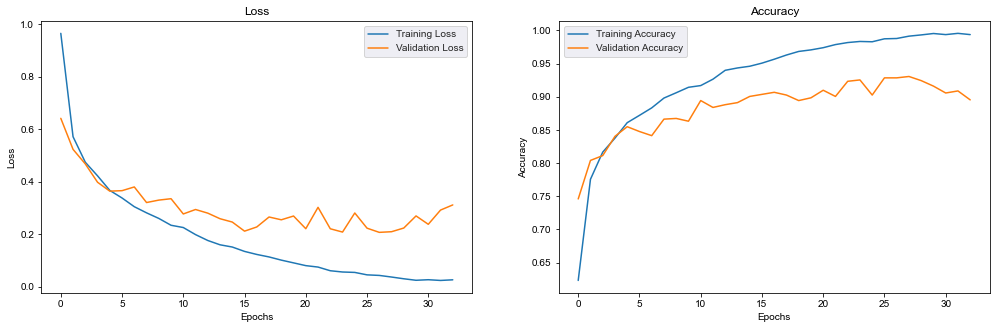

In [9]:
# Membuat list nilai loss dan akurasi dari model
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

# Membuat plot
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
sns.set_style("darkgrid")

# Plot loss
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss')
ax[0].legend()

# Plot accuracy
ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

In [10]:
# Load weights
model.load_weights('Nasnetbest_weights.h5')

# Evaluate model on validation set
loss, accuracy = model.evaluate(validation_generator, verbose=1)
print('Validation Accuracy: {:.2%}'.format(accuracy))
print('Validation Loss: {:.2f}'.format(loss))

31/31 [==============================] - 36s 1s/step - loss: 0.2093 - accuracy: 0.9305
Validation Accuracy: 93.05%
Validation Loss: 0.21


In [12]:
# Mendapatkan label yang sesuai dengan prediksi
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}

In [13]:
# Memuat bobot terbaik yang disimpan selama pelatihan
model.load_weights('Nasnetbest_weights.h5')

# Mengumpulkan semua prediksi dan label asli
y_pred = []
labels = []
for i in range(len(validation_generator)):
    batch_data, batch_labels = validation_generator[i]
    batch_pred = model.predict(batch_data)
    y_pred.extend(np.argmax(batch_pred, axis=1))
    labels.extend(np.argmax(batch_labels, axis=1))

1/1 [==============================] - 3s 3s/step


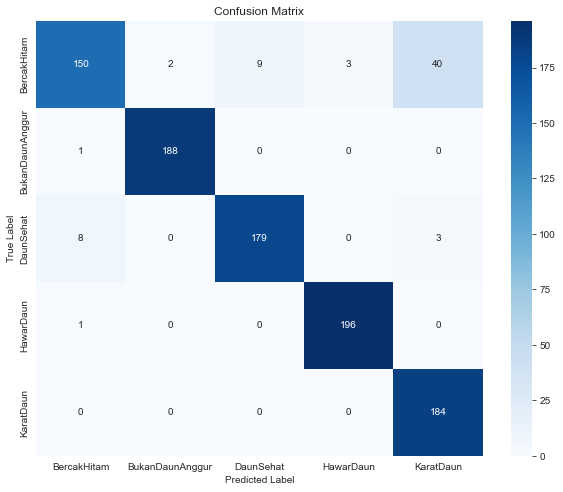

Classification Report:
                 precision    recall  f1-score   support

    BercakHitam       0.94      0.74      0.82       204
BukanDaunAnggur       0.99      0.99      0.99       189
      DaunSehat       0.95      0.94      0.95       190
      HawarDaun       0.98      0.99      0.99       197
      KaratDaun       0.81      1.00      0.90       184

       accuracy                           0.93       964
      macro avg       0.93      0.93      0.93       964
   weighted avg       0.94      0.93      0.93       964



In [14]:
# Menghitung matriks kebingungan
cm = confusion_matrix(labels, y_pred)

# Menghitung akurasi
accuracy = np.sum(labels == y_pred) / len(labels)

# Membuat plot matriks kebingungan
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Mencetak laporan klasifikasi
classification_report_str = classification_report(labels, y_pred, target_names=class_labels.values())
print("Classification Report:")
print(classification_report_str)

In [15]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi .tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('nasnet.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


19561608